In [1]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *

D:\Anaconda\envs\fastai\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
path = "../data/preprocessed/BikeRental_preprocessed.csv"
df = pd.read_csv("../data/preprocessed/BikeRental_preprocessed.csv")
df.head()

,Unnamed: 0,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,0,2011-01-01 00:00:00,1.0,0.0,1,0,0.0,5,0.0,1.0,0.224490,0.81,0.0,0.015369
1,1,2011-01-01 01:00:00,1.0,0.0,1,1,0.0,5,0.0,1.0,0.204082,0.80,0.0,0.039959
2,2,2011-01-01 02:00:00,1.0,0.0,1,2,0.0,5,0.0,1.0,0.204082,0.80,0.0,0.031762
3,3,2011-01-01 03:00:00,1.0,0.0,1,3,0.0,5,0.0,1.0,0.224490,0.75,0.0,0.012295
4,4,2011-01-01 04:00:00,1.0,0.0,1,4,0.0,5,0.0,1.0,0.224490,0.75,0.0,0.000000


In [3]:
cat_names = ['season', 'yr', 'weathersit', "workingday", "holiday"]
cont_names = ['mnth', 'hr', 'weekday', 'temp', "windspeed", "hum"]
procs = [Categorify]

In [4]:
dls = TabularDataLoaders.from_df(df, path, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="cnt", bs=64)

In [5]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [6]:
to = TabularPandas(df, procs=[Categorify],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='cnt',
                   splits=splits)

In [7]:
to.xs.iloc[:2]

,season,yr,weathersit,workingday,holiday,mnth,hr,weekday,temp,windspeed,hum
14033,3,2,11,2,1,8,17,1,0.77551,0.157870,0.62
8404,4,1,1,1,1,12,4,5,0.22449,0.193018,0.65


In [8]:
dls = to.dataloaders(bs=64)

In [9]:
dls.show_batch()

,season,yr,weathersit,workingday,holiday,mnth,hr,weekday,temp,windspeed,hum,cnt
0,4,0,1,1,0,10.0,3.0,1.0,0.387755,0.122840,0.82,0.005123
1,2,1,2,0,0,3.0,7.0,6.0,0.387755,0.386035,0.94,0.038934
2,4,1,1,0,0,9.0,17.0,6.0,0.551020,0.350888,0.35,0.739754
3,3,0,2,1,0,7.0,13.0,2.0,0.734694,0.122840,0.70,0.142418
4,4,0,3,1,0,12.0,7.0,2.0,0.428571,0.122840,1.00,0.046107
5,3,1,2,0,0,7.0,13.0,5.0,0.959184,0.298225,0.31,0.367828
6,4,1,1,1,0,10.0,4.0,3.0,0.387755,0.298225,0.50,0.009221
7,3,1,1,0,0,8.0,3.0,5.0,0.653061,0.105325,0.69,0.037910
8,3,1,1,1,0,9.0,7.0,3.0,0.530612,0.000000,0.77,0.584016
9,1,0,2,0,1,2.0,0.0,0.0,0.326531,0.386035,0.42,0.036885


In [14]:
learn = tabular_learner(dls,
                        metrics=R2Score(),
                       layers=[500,250])

In [ ]:
learn.load('fastai_learner_random_split')

In [15]:
learn.fit_one_cycle(175)

epoch,train_loss,valid_loss,r2_score,time
0,0.020016,0.017283,0.482679,00:07
1,0.016708,0.015288,0.542404,00:07
2,0.015427,0.015440,0.537833,00:07
3,0.014977,0.014920,0.553406,00:11
4,0.014565,0.014167,0.575938,00:10
5,0.014504,0.013684,0.590393,00:08
6,0.014262,0.013810,0.586646,00:10
7,0.013999,0.012810,0.616574,00:09
8,0.014207,0.013289,0.602236,00:07
9,0.014438,0.012234,0.633798,00:11


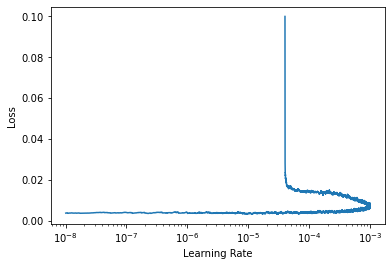

In [16]:
learn.recorder.plot_lr_find()

In [17]:
learn.show_results()

,season,yr,weathersit,workingday,holiday,mnth,hr,weekday,temp,windspeed,hum,cnt,cnt_pred
0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,4.0,0.326531,0.263195,0.49,0.019467,0.035920
1,1.0,1.0,1.0,2.0,1.0,2.0,19.0,1.0,0.265306,0.157870,0.26,0.147541,0.139383
2,1.0,1.0,1.0,2.0,1.0,1.0,17.0,0.0,0.224490,0.263195,0.30,0.159836,0.142999
3,3.0,1.0,1.0,2.0,1.0,8.0,13.0,3.0,0.755102,0.000000,0.58,0.209016,0.158438
4,1.0,2.0,1.0,2.0,1.0,2.0,4.0,2.0,0.326531,0.193018,0.71,0.001025,-0.002147
5,2.0,1.0,1.0,2.0,1.0,4.0,19.0,2.0,0.428571,0.298225,0.62,0.178279,0.256155
6,1.0,1.0,11.0,2.0,1.0,3.0,17.0,1.0,0.346939,0.228047,0.62,0.221311,0.175560
7,2.0,1.0,1.0,2.0,1.0,4.0,12.0,0.0,0.632653,0.543905,0.36,0.159836,0.207504
8,4.0,2.0,11.0,1.0,1.0,11.0,22.0,5.0,0.306122,0.122840,0.57,0.147541,0.140228


In [18]:
df.loc[1]

Unnamed: 0                      1
datetime      2011-01-01 01:00:00
season                          1
yr                              0
mnth                            1
hr                              1
holiday                         0
weekday                         5
workingday                      0
weathersit                      1
temp                     0.204082
hum                           0.8
windspeed                       0
cnt                      0.039959
Name: 1, dtype: object

In [20]:
learn.save('fastai_learner_random_split')

Path('models/fastai_learner_random_split.pth')

In [118]:
learn.predict(df.loc[1].drop("cnt"))

(   season   yr  weathersit  workingday  holiday  mnth   hr  weekday      temp  \
 0     1.0  1.0         1.0         1.0      1.0   1.0  1.0      5.0  0.204082   
 
    windspeed  hum       cnt  
 0        0.0  0.8  0.031137  ,
 tensor([0.0311]),
 tensor([0.0311]))

In [125]:
test_df = df.copy()
test_df.drop(['cnt'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

In [127]:
test_df

,Unnamed: 0,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,0,2011-01-01 00:00:00,1.0,0.0,1,0,0.0,5,0.0,1.0,0.224490,0.81,0.000000
1,1,2011-01-01 01:00:00,1.0,0.0,1,1,0.0,5,0.0,1.0,0.204082,0.80,0.000000
2,2,2011-01-01 02:00:00,1.0,0.0,1,2,0.0,5,0.0,1.0,0.204082,0.80,0.000000
3,3,2011-01-01 03:00:00,1.0,0.0,1,3,0.0,5,0.0,1.0,0.224490,0.75,0.000000
4,4,2011-01-01 04:00:00,1.0,0.0,1,4,0.0,5,0.0,1.0,0.224490,0.75,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,17539,2012-12-31 19:00:00,1.0,1.0,12,19,0.0,0,1.0,2.0,0.244898,0.60,0.193018
17540,17540,2012-12-31 20:00:00,1.0,1.0,12,20,0.0,0,1.0,2.0,0.244898,0.60,0.193018
17541,17541,2012-12-31 21:00:00,1.0,1.0,12,21,0.0,0,1.0,1.0,0.244898,0.60,0.193018
17542,17542,2012-12-31 22:00:00,1.0,1.0,12,22,0.0,0,1.0,1.0,0.244898,0.56,0.157870


In [128]:
type(learn.get_preds(dl=dl))

tuple

---

# With Sebastians train and test split

In [215]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *

In [216]:
path = "../data/preprocessed/BikeRental_preprocessed.csv"
df = pd.read_csv("../data/preprocessed/BikeRental_preprocessed.csv", index_col=[0])
min_max = pd.read_csv("../data/preprocessed/cnt_min_max.csv")
df.head()

,Unnamed: 0,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,0,2011-01-01 00:00:00,1.0,0.0,1,0,0.0,5,0.0,1.0,0.224490,0.81,0.0,0.015369
1,1,2011-01-01 01:00:00,1.0,0.0,1,1,0.0,5,0.0,1.0,0.204082,0.80,0.0,0.039959
2,2,2011-01-01 02:00:00,1.0,0.0,1,2,0.0,5,0.0,1.0,0.204082,0.80,0.0,0.031762
3,3,2011-01-01 03:00:00,1.0,0.0,1,3,0.0,5,0.0,1.0,0.224490,0.75,0.0,0.012295
4,4,2011-01-01 04:00:00,1.0,0.0,1,4,0.0,5,0.0,1.0,0.224490,0.75,0.0,0.000000


In [217]:
min_max.head()

,Unnamed: 0,max,min
0,cnt,977.0,1.0


In [218]:
cat_names = ['season', 'yr', 'weathersit', "workingday", "holiday"]
cont_names = ['mnth', 'hr', 'weekday', 'temp', "windspeed", "hum"]
procs = [Categorify]

In [219]:
dls = TabularDataLoaders.from_df(df, path, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="cnt", bs=64)

In [220]:
split = 0.8
splits = (list(range(0,round(len(df)*split))),list(range(round(len(df)*split), len(df))))

In [221]:
to = TabularPandas(df, procs=[Categorify],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='cnt',
                   splits=splits)

In [222]:
dls = to.dataloaders(bs=64)

In [227]:
learn = tabular_learner(dls,
                        metrics=R2Score(),
                        layers=[500,250],
                        n_out=1,
                        loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=6.30957365501672e-05)

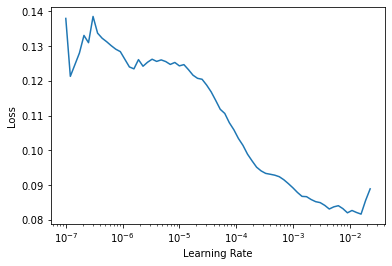

In [228]:
learn.lr_find()

# check if model already exists

In [ ]:
learn.load('fastai_learner')

In [229]:
learn.fit_one_cycle(300)

epoch,train_loss,valid_loss,r2_score,time
0,0.016689,0.035864,0.293326,00:06
1,0.014936,0.035018,0.309985,00:06
2,0.013985,0.034279,0.324542,00:06
3,0.013229,0.028306,0.442237,00:07
4,0.012771,0.028435,0.439700,00:07
5,0.012913,0.028584,0.436766,00:08
6,0.012150,0.026968,0.468617,00:07
7,0.012118,0.025980,0.488073,00:07
8,0.011392,0.025964,0.488393,00:06
9,0.011312,0.025240,0.502650,00:10


In [239]:
learn.save('fastai_learner')

Path('models/fastai_learner.pth')

In [230]:
learn.show_results()

,season,yr,weathersit,workingday,holiday,mnth,hr,weekday,temp,windspeed,hum,cnt,cnt_pred
0,4.0,2.0,1.0,2.0,1.0,10.0,23.0,1.0,0.387755,0.000000,0.71,0.202869,0.101773
1,4.0,2.0,1.0,2.0,1.0,12.0,15.0,3.0,0.306122,0.000000,0.39,0.275615,0.242375
2,4.0,2.0,1.0,1.0,1.0,10.0,21.0,6.0,0.367347,0.122840,0.87,0.114754,0.141590
3,4.0,2.0,14.0,1.0,1.0,12.0,6.0,5.0,0.346939,0.122840,0.93,0.019467,0.045081
4,4.0,2.0,45.0,2.0,1.0,11.0,4.0,1.0,0.285714,0.228047,0.81,0.004098,0.025552
5,4.0,2.0,1.0,1.0,1.0,11.0,19.0,5.0,0.448980,0.105325,0.51,0.288934,0.249515
6,4.0,2.0,14.0,2.0,1.0,10.0,1.0,3.0,0.612245,0.000000,0.94,0.024590,0.045910
7,4.0,2.0,14.0,2.0,1.0,10.0,0.0,4.0,0.551020,0.122840,0.83,0.056352,0.060058
8,3.0,2.0,1.0,2.0,1.0,9.0,4.0,4.0,0.489796,0.000000,0.77,0.009221,0.022203


In [21]:
test_df = df[round(len(df)*0.8):].copy()

In [22]:
test_df.rename(columns={"cnt":"cnt_real"})
dl = learn.dls.test_dl(test_df)

In [23]:
preds = learn.get_preds(dl=dl)

In [24]:
test_df["cnt_pred"] = [preds[0][i].item() for i in range(0, len(preds[0]))]
test_df

,Unnamed: 0,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,cnt_pred
14035,14035,2012-08-07 19:00:00,3.0,1.0,8,19,0.0,1,1.0,2.0,0.755102,0.66,0.122840,0.623975,0.609578
14036,14036,2012-08-07 20:00:00,3.0,1.0,8,20,0.0,1,1.0,2.0,0.734694,0.70,0.157870,0.457992,0.439174
14037,14037,2012-08-07 21:00:00,3.0,1.0,8,21,0.0,1,1.0,2.0,0.714286,0.74,0.000000,0.323770,0.262887
14038,14038,2012-08-07 22:00:00,3.0,1.0,8,22,0.0,1,1.0,1.0,0.714286,0.74,0.122840,0.228484,0.232728
14039,14039,2012-08-07 23:00:00,3.0,1.0,8,23,0.0,1,1.0,1.0,0.714286,0.79,0.000000,0.140369,0.168613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,17539,2012-12-31 19:00:00,1.0,1.0,12,19,0.0,0,1.0,2.0,0.244898,0.60,0.193018,0.120902,0.139918
17540,17540,2012-12-31 20:00:00,1.0,1.0,12,20,0.0,0,1.0,2.0,0.244898,0.60,0.193018,0.090164,0.084783
17541,17541,2012-12-31 21:00:00,1.0,1.0,12,21,0.0,0,1.0,1.0,0.244898,0.60,0.193018,0.091189,0.104363
17542,17542,2012-12-31 22:00:00,1.0,1.0,12,22,0.0,0,1.0,1.0,0.244898,0.56,0.157870,0.061475,0.074726


In [25]:
test_df["cnt_norm"] = test_df["cnt"].apply(lambda x: x * (977 - 1) + 1)

In [26]:
test_df["cnt_pred_norm"] = test_df["cnt_pred"].apply(lambda x: round(x * (977 - 1) + 1))

In [27]:
test_df

,Unnamed: 0,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,cnt_pred,cnt_norm,cnt_pred_norm
14035,14035,2012-08-07 19:00:00,3.0,1.0,8,19,0.0,1,1.0,2.0,0.755102,0.66,0.122840,0.623975,0.609578,610.0,596
14036,14036,2012-08-07 20:00:00,3.0,1.0,8,20,0.0,1,1.0,2.0,0.734694,0.70,0.157870,0.457992,0.439174,448.0,430
14037,14037,2012-08-07 21:00:00,3.0,1.0,8,21,0.0,1,1.0,2.0,0.714286,0.74,0.000000,0.323770,0.262887,317.0,258
14038,14038,2012-08-07 22:00:00,3.0,1.0,8,22,0.0,1,1.0,1.0,0.714286,0.74,0.122840,0.228484,0.232728,224.0,228
14039,14039,2012-08-07 23:00:00,3.0,1.0,8,23,0.0,1,1.0,1.0,0.714286,0.79,0.000000,0.140369,0.168613,138.0,166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,17539,2012-12-31 19:00:00,1.0,1.0,12,19,0.0,0,1.0,2.0,0.244898,0.60,0.193018,0.120902,0.139918,119.0,138
17540,17540,2012-12-31 20:00:00,1.0,1.0,12,20,0.0,0,1.0,2.0,0.244898,0.60,0.193018,0.090164,0.084783,89.0,84
17541,17541,2012-12-31 21:00:00,1.0,1.0,12,21,0.0,0,1.0,1.0,0.244898,0.60,0.193018,0.091189,0.104363,90.0,103
17542,17542,2012-12-31 22:00:00,1.0,1.0,12,22,0.0,0,1.0,1.0,0.244898,0.56,0.157870,0.061475,0.074726,61.0,74


---

In [65]:
learn.fit_one_cycle(300)

epoch,train_loss,valid_loss,r2_score,time
0,0.010994,0.010949,0.687418,00:05
1,0.011460,0.010663,0.695568,00:05
2,0.011242,0.010901,0.688791,00:05
3,0.011073,0.010658,0.695730,00:05
4,0.011024,0.010633,0.696441,00:05
5,0.010964,0.010417,0.702590,00:05
6,0.011347,0.010353,0.704420,00:05
7,0.011261,0.010490,0.700519,00:05
8,0.011103,0.010102,0.711593,00:05
9,0.011033,0.010338,0.704871,00:05


In [66]:
learn.show_results()

,season,yr,weathersit,workingday,holiday,mnth,hr,weekday,temp,windspeed,hum,cnt,cnt_pred
0,1.0,1.0,1.0,2.0,1.0,-1.012126,-0.939616,0.496552,-1.008358,0.262846,0.943577,0.006148,0.033775
1,1.0,2.0,11.0,2.0,1.0,-1.302233,0.216885,0.496552,-0.389097,-0.709238,0.425083,0.186475,0.178114
2,1.0,1.0,1.0,1.0,1.0,-1.592339,-0.072240,1.495779,-1.834040,0.262846,-1.026702,0.100410,0.093617
3,4.0,2.0,11.0,1.0,1.0,1.018616,0.216885,0.996166,0.746215,2.693058,-0.300809,0.726434,0.611371
4,4.0,2.0,1.0,2.0,1.0,1.598829,-1.373305,-0.502675,-0.182677,-0.223196,0.217685,0.008197,0.008129
5,2.0,1.0,11.0,2.0,1.0,-0.141808,-0.072240,-1.002288,1.365476,0.505460,-0.560057,0.153689,0.145956
6,3.0,2.0,1.0,1.0,1.0,0.438404,-0.361366,0.996166,1.468686,0.262846,0.113986,0.283811,0.338465
7,4.0,2.0,1.0,1.0,1.0,1.018616,-0.361366,0.996166,-0.698728,-0.830545,-0.663755,0.271516,0.266714
8,2.0,1.0,11.0,2.0,1.0,-0.141808,-0.650491,-0.003061,1.159055,-0.466624,0.839878,0.320697,0.324045


---

# Fastbook
More detailed description. See [here](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb).

In [1]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *

D:\Anaconda\envs\fastai\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
path = "../data/preprocessed/BikeRental_preprocessed.csv"
df = pd.read_csv("../data/preprocessed/BikeRental_preprocessed.csv", index_col=[0])
df.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,2011-01-01 00:00:00,1.0,0.0,1,0,0.0,5,0.0,1.0,0.224490,0.81,0.0,0.015369
1,2011-01-01 01:00:00,1.0,0.0,1,1,0.0,5,0.0,1.0,0.204082,0.80,0.0,0.039959
2,2011-01-01 02:00:00,1.0,0.0,1,2,0.0,5,0.0,1.0,0.204082,0.80,0.0,0.031762
3,2011-01-01 03:00:00,1.0,0.0,1,3,0.0,5,0.0,1.0,0.224490,0.75,0.0,0.012295
4,2011-01-01 04:00:00,1.0,0.0,1,4,0.0,5,0.0,1.0,0.224490,0.75,0.0,0.000000


In [3]:
splits = (list(range(0,15789)),list(range(15789, len(df))))

In [4]:
cat = ['season', 'yr', 'weathersit', "workingday", "holiday"]
cont = ['mnth', 'hr', 'weekday', 'temp', "windspeed", "hum"]
procs = [Categorify]

In [5]:
to = TabularPandas(df, procs, cat, cont, y_names="cnt", splits=splits)

In [6]:
len(to.train),len(to.valid)

(15789, 1755)

In [7]:
dls = to.dataloaders(1024)

In [8]:
y = to.train.y
y.min(),y.max()

(0.0, 1.0)

In [9]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss, metrics=R2Score())

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.0005754399462603033)

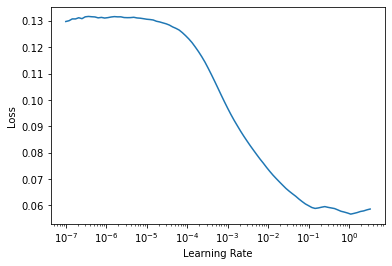

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,r2_score,time
0,0.091580,0.107805,-1.927228,00:01
1,0.051955,0.072402,-0.965918,00:01
2,0.037028,0.055794,-0.514973,00:01
3,0.029080,0.050295,-0.365652,00:01
4,0.023955,0.037711,-0.023968,00:01
5,0.020381,0.025597,0.304972,00:01
6,0.017834,0.018590,0.495241,00:01
7,0.015969,0.017603,0.522040,00:01
8,0.014615,0.017728,0.518638,00:01
9,0.013632,0.017530,0.524006,00:01


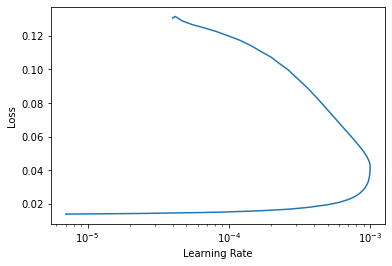

In [12]:
learn.recorder.plot_lr_find()

In [124]:
learn.show_results()

,season,yr,weathersit,workingday,holiday,mnth,hr,weekday,temp,windspeed,hum,cnt,cnt_pred
0,4.0,2.0,14.0,1.0,1.0,11.0,12.0,5.0,0.346939,0.543905,0.46,0.402664,0.469546
1,4.0,2.0,1.0,1.0,1.0,10.0,3.0,5.0,0.408163,0.157870,0.77,0.028689,0.000415
2,4.0,2.0,14.0,2.0,1.0,11.0,5.0,4.0,0.306122,0.193018,0.66,0.025615,0.060395
3,4.0,2.0,14.0,2.0,1.0,11.0,4.0,1.0,0.326531,0.228047,0.66,0.005123,0.024297
4,4.0,2.0,1.0,2.0,1.0,11.0,8.0,2.0,0.265306,0.350888,0.56,0.706967,0.686090
5,4.0,2.0,14.0,2.0,1.0,11.0,2.0,0.0,0.285714,0.193018,0.56,0.005123,0.001976
6,4.0,2.0,1.0,1.0,1.0,11.0,22.0,5.0,0.367347,0.105325,0.71,0.196721,0.134162
7,1.0,2.0,14.0,2.0,1.0,12.0,23.0,4.0,0.224490,0.105325,0.65,0.059426,0.059174
8,4.0,2.0,1.0,1.0,2.0,11.0,16.0,3.0,0.448980,0.000000,0.33,0.185451,0.381233
